# Clustering Colors to Compress Images

## Motivation
Suppose we have a $H \times W$ image with $C = 3$ color channels (red, green and blue). Each color channel is represented by 8 bits.

**Exercise 1: Assuming we don't do any compression, how many bits will you need to store the image on disk?**

You'll need $H \times W \times 3 \times 8 = 24 H W$ bits

In this lesson, we will use K-means clustering to lossily compress images.

Basically, observe that with $C$ color channels and 8 bits per channel, we can represent $2^{8C}$ colors. This is a massive number of colors (for $C = 3$, this is almost 17 million colors). Humans probably don't need a color palette this big.

Let us instead use a color palette with $K$ colors in it. We need $8CK$ bits to store the color palette. Then, for a $H \times W \times C$ image, we can turn each pixel into a single integer representing the index of the color in the palette that we should use. So, a pixel with a value $212$ would use the $212^{th}$ color in the palette.

**Exercise 2: Assuming we have already stored the color palette, how many bits do we need to store the compressed image?**

Since we have $K$ colors, assuming a fixed length encoding, we need $\log_2{K}$ bits per pixel to represent which color it represents. Therefore, we need $H \times W \times \log_2{K}$ bits to store the entire image. If we only ever wanted to express complete images, we could use a Hoffman encoding, and do even better.

**Exercise 3: Assume we have $N$ images of dimension $H \times W \times C$ that we compress with a $K$-color palette. What is the compression ratio (i.e. $\frac{size_{compressed}}{size_{original}}$), as an algebraic expression, for the dataset?**

Since the number of images, and the dimensions of each image don't change, the compression ratio is entirely the ratio of the new size of each pixel compared to the old size of each pixel. Assuming each color channel is stored with 8 bits:
$$\frac{size_{compressed}}{size_{original}} = \frac{\log_2{K}}{8C}$$

**Exercise 4: For $N = 10,000$, $H = W = 512$, $C = 3$, and $K = 1000$, what is the compression ratio, as a number?**

In [1]:
import math
palette_size = 1000
color_channels = 3
bits_per_channel = 8
compression_ratio = math.log(palette_size, 2) / (bits_per_channel * color_channels)
print("With K=%d, C=%d, and %d bits per color channel, the compression ratio is %.3f%%" % 
      (palette_size, color_channels, bits_per_channel, compression_ratio * 100.0))

With K=1000, C=3, and 8 bits per color channel, the compression ratio is 41.524%


## Clustering
Once we have chosen $K$, we need to figure out which colors to put in our palette. This can be done manually, which is time consuming and error prone. A better approach is to take a dataset of images and select the best colors with machine learning.

We can model the problem of picking a color palette as **clustering**, an unsupervised machine learning problem. The goal in clustering is to take a set of vectors (e.g. the $C$ dimensional colors) and pick a set of $K$ vectors that most accurately summarize them.

The clustering algorithm that we will use in this assignment is called $K$-means clustering.

**Exercise 4: Read Section 9.1 (K-means Clustering) in [Pattern Recognition and Machine Learning](https://www.amazon.com/gp/product/0387310738/). If you don't have the book, read section 10.3.1 (K-Means Clustering) from the free book [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf)**. I did find an online link to the chapter in the book though:

http://www.cse.psu.edu/~rtc12/CSE586Spring2010/papers/prmlMixturesEM.pdf

## Images
For a sample dataset, I've taken some free stock photos from [Pexels](https://www.pexels.com/).

Let's load them into Numpy arrays.

Here are the first three images


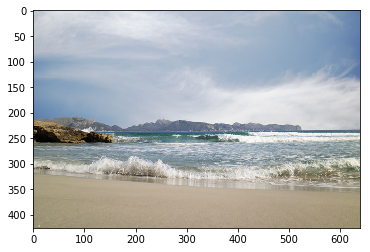

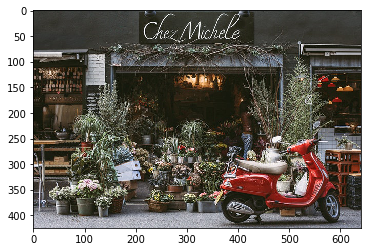

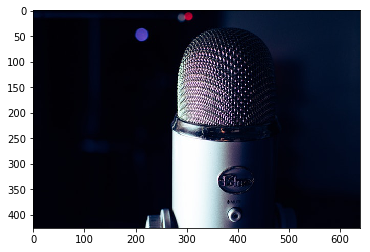

In [12]:
IMAGE_DIRECTORY = './Lesson7Images'
MAX_NUMBER_OF_IMAGES_SHOWN_AT_ONCE = 8

import imageio
import glob
from os import path
import matplotlib.pyplot as plt


def load_images(image_directory):
    """
    Read all files from the given directory of images.
    
    Return a list of images. Each image is a numpy array of shape (H, W, C).
    Where H is height, W is width, and C number of color channels. For
    a given image I, I[h][w][c] is the channel c intensity of the pixel
    at row h and column w.
    """
    image_paths = glob.glob(path.join(image_directory, '*.j*g'))
    images = [imageio.imread(image_path) for image_path in image_paths]
    return images

def show_image(image):
    plt.imshow(image)
    plt.show()

images = load_images(IMAGE_DIRECTORY)

print("Here are the first three images")
show_image(images[0])
show_image(images[1])
show_image(images[2])

## KMeans

Now you will implement the K-means based image compression that we described earlier.

In [9]:
import numpy as np
from sklearn.cluster import KMeans

class KMeansImageCompressor():
    def __init__(self, K, images, num_samples_for_kmeans=20000):
        """
        @param K - The number of colors to use
            in our color palette.
        @param images - A list of images. Each image is a numpy array
            with three dimensions. The first dimension is height,
            second is width, and third is color channel. All
            images will have the same number of color channels,
            but may have different heights and widths.
        @param num_samples_for_kmeans - Since images have lots of pixels,
            running k-means on the entire set of pixels is slow,
            so we will only compute the color palette on a random
            sample of pixels. This is the size of that sample.
        """
        unsampled_pixels = self._to_pixels(images)
        
        pixel_indices = np.random.randint(
            unsampled_pixels.shape[0],
            size=num_samples_for_kmeans,
        )
        pixels = unsampled_pixels[pixel_indices, :]
        
        self._color_palette_obj = self._compute_color_palette(K, pixels)
        self._color_palette = self._to_color_palette(
            self._color_palette_obj,
        ).astype(np.uint8)
    
    def color_palette(self):
        return self._color_palette
    
    def compress(self, image):
        """
        @param image - An np.array of shape (H, W, C) representing an image
            with height H, width W, and number of color channels C.
        
        @return An np.array of shape (H, W) where the value at position
            (h, w) is the color index (between 0 and K -1, both inclusive)
            assigned to the pixel at position (h, w) in the input image.
        """
        (H, W, _) = image.shape
        pixels = self._to_pixels(np.array([image]))
        compressed_pixels = self._assign_to_color_palette(
            self._color_palette_obj,
            pixels,
        )
        return compressed_pixels.reshape((H, W))
    
    
    def uncompress(self, compressed_image):
        """
        The approximate inverse of self.compress. This
        is approximate because the compression is lossy.
        """
        (H, W) = compressed_image.shape
        (_, C) = self._color_palette.shape
        return np.array([
            self._color_palette[i]
            for i in compressed_image.flatten()
        ]).reshape((H, W, C))
    
    def _to_pixels(self, images):
        """
        Exercise 5: Turn a list of images into pixels.
        
        @param images - A list of images. Each image is a numpy array
            with three dimensions. The first dimension is height,
            second is width, and third is color channel. All
            images will have the same number of color channels,
            but may have different heights and widths.
        
        @return An np.array of shape (N, C) where N is the number
            of pixels in all of the input images together and
            C is the number of color channels.
            An image of size (H, W, C) produces HW pixels.
            This function will assemble all the pixels
            in all the images into a single np.array.
            
        Hint:
        https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html
        https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html
        """
        def flatten_image(img):
            (h,w,c) = img.shape
            return img.reshape(h*w, c)
        ret = np.concatenate(np.array(list(map(flatten_image, images))))
        return ret
    
    def _compute_color_palette(self, K, pixels):
        """
        Exercise 6: Find the color pallete given pixels in the dataset.
        
        This function will compute the self.K cluster centers
        representing the colors in our color palette by
        doing K-means clustering on the pixels argument
        
        If you have any other fields that you would like to set,
        feel free to do so.
        
        @param K - The number of colors to include in the palette.
        
        @param pixels - An np.array of shape (N, C) where C
            is the number of color channels and N is the
            number of pixels in self.images.
        
        @return Some object representing the color palette.
            
        Hint:
        http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
        """
        palette = KMeans(n_clusters=K)
        palette.fit(pixels)
        return palette
    
    def _to_color_palette(self, color_palette_obj):
        """
        Exercise 7: Get the color palette.
        
        @param color_palette_obj - An object representing the K
            color palette. This is the output type of self._compute_color_palette.
        
        @return An np.array of shape (self.K, C) representing the K colors
            used in the color palette.
        """
        return color_palette_obj.cluster_centers_
    
    def _assign_to_color_palette(self, color_palette_obj, pixels):
        """
        Exercise 8: Apply the color palette to the image.
        
        @param color_palette_obj - An object representing the K
            color palette. This is the output type of self._compute_color_palette.
        
        @param pixels - An np.array of shape (N, C) representing the input pixels.
        
        @return An np.array of shape (N, 1) where each pixel has been turned
            into an integer in the range [0, K - 1] representing the
            color it is given.
        """
        palette = self._to_color_palette(color_palette_obj)
        labelled_pixels = color_palette_obj.predict(pixels)
        ret = np.array(list(map(lambda i: palette[i], labelled_pixels)))
        return labelled_pixels

In [4]:
import numpy as np
from sklearn.mixture import GaussianMixture

class GaussianImageCompressor():
    def __init__(self, K, images, num_samples_for_gaussian=10000):
        """
        @param K - The number of colors to use
            in our color palette.
        @param images - A list of images. Each image is a numpy array
            with three dimensions. The first dimension is height,
            second is width, and third is color channel. All
            images will have the same number of color channels,
            but may have different heights and widths.
        @param num_samples_for_kmeans - Since images have lots of pixels,
            running k-means on the entire set of pixels is slow,
            so we will only compute the color palette on a random
            sample of pixels. This is the size of that sample.
        """
        unsampled_pixels = self._to_pixels(images)
        
        pixel_indices = np.random.randint(
            unsampled_pixels.shape[0],
            size=num_samples_for_gaussian,
        )
        pixels = unsampled_pixels[pixel_indices, :]
        
        self._color_palette_obj = self._compute_color_palette(K, pixels)
        self._color_palette = self._to_color_palette(
            self._color_palette_obj,
        ).astype(np.uint8)
    
    def color_palette(self):
        return self._color_palette
    
    def compress(self, image):
        """
        @param image - An np.array of shape (H, W, C) representing an image
            with height H, width W, and number of color channels C.
        
        @return An np.array of shape (H, W) where the value at position
            (h, w) is the color index (between 0 and K -1, both inclusive)
            assigned to the pixel at position (h, w) in the input image.
        """
        (H, W, _) = image.shape
        pixels = self._to_pixels(np.array([image]))
        compressed_pixels = self._assign_to_color_palette(
            self._color_palette_obj,
            pixels,
        )
        return compressed_pixels.reshape((H, W))
    
    
    def uncompress(self, compressed_image):
        """
        The approximate inverse of self.compress. This
        is approximate because the compression is lossy.
        """
        (H, W) = compressed_image.shape
        (_, C) = self._color_palette.shape
        return np.array([
            self._color_palette[i]
            for i in compressed_image.flatten()
        ]).reshape((H, W, C))
    
    def _to_pixels(self, images):
        """
        Exercise 5: Turn a list of images into pixels.
        
        @param images - A list of images. Each image is a numpy array
            with three dimensions. The first dimension is height,
            second is width, and third is color channel. All
            images will have the same number of color channels,
            but may have different heights and widths.
        
        @return An np.array of shape (N, C) where N is the number
            of pixels in all of the input images together and
            C is the number of color channels.
            An image of size (H, W, C) produces HW pixels.
            This function will assemble all the pixels
            in all the images into a single np.array.
            
        Hint:
        https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html
        https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html
        """
        def flatten_image(img):
            (h,w,c) = img.shape
            return img.reshape(h*w, c)
        ret = np.concatenate(np.array(list(map(flatten_image, images))))
        return ret
    
    def _compute_color_palette(self, K, pixels):
        """
        Exercise 6: Find the color pallete given pixels in the dataset.
        
        This function will compute the self.K cluster centers
        representing the colors in our color palette by
        doing K-means clustering on the pixels argument
        
        If you have any other fields that you would like to set,
        feel free to do so.
        
        @param K - The number of colors to include in the palette.
        
        @param pixels - An np.array of shape (N, C) where C
            is the number of color channels and N is the
            number of pixels in self.images.
        
        @return Some object representing the color palette.
            
        Hint:
        http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
        """
        palette = GaussianMixture(n_components=K)
        palette.fit(pixels)
        return palette
    
    def _to_color_palette(self, color_palette_obj):
        """
        Exercise 7: Get the color palette.
        
        @param color_palette_obj - An object representing the K
            color palette. This is the output type of self._compute_color_palette.
        
        @return An np.array of shape (self.K, C) representing the K colors
            used in the color palette.
        """
        return color_palette_obj.means_
    
    def _assign_to_color_palette(self, color_palette_obj, pixels):
        """
        Exercise 8: Apply the color palette to the image.
        
        @param color_palette_obj - An object representing the K
            color palette. This is the output type of self._compute_color_palette.
        
        @param pixels - An np.array of shape (N, C) representing the input pixels.
        
        @return An np.array of shape (N, 1) where each pixel has been turned
            into an integer in the range [0, K - 1] representing the
            color it is given.
        """
        palette = self._to_color_palette(color_palette_obj)
        labelled_pixels = color_palette_obj.predict(pixels)
        ret = np.array(list(map(lambda i: palette[i], labelled_pixels)))
        return labelled_pixels

## Running the Compressor

Now that we've implemented our compressor, let's use it.

We'll start off with $K = 2$. To see how it performs, we will compress and uncompress an image (called
a reconstruction). We then plot the image with its reconstruction to see if we can visually tell the difference.

**
Exercise 9: Play around with different choices of $K$ until you find one that gives reconstructions that are visually indistinguishable from the original. If you had $N = 10,000$, $H = W = 512$, and $C = 3$, what would your compression ratio be for this choice of $K$?
**

You need a K of about 1024 for visually indistinguishable (41.7% compression ratio), but you need only 512 for very close results (37.5% compression ratio). This smaller palette fails to accurately portray gradients.

In [5]:
import math
palette_size = 512
color_channels = 3
bits_per_channel = 8
compression_ratio = math.log(palette_size, 2) / (bits_per_channel * color_channels)
print("With K=%d, C=%d, and %d bits per color channel, the compression ratio is %.3f%%" % 
      (palette_size, color_channels, bits_per_channel, compression_ratio * 100.0))

With K=512, C=3, and 8 bits per color channel, the compression ratio is 37.500%


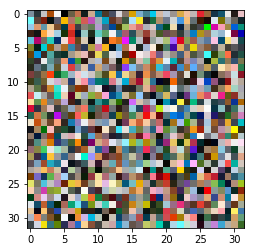

In [11]:
import math

K = 1024

# Let's run the compressor.

USE_GAUSSIAN = False


if USE_GAUSSIAN:
    compressor = GaussianImageCompressor(K, images)
else:
    compressor = KMeansImageCompressor(K, images)
    
# Here's the color palette it chose.
color_palette = compressor.color_palette()
sqrt_K = int(math.ceil(math.sqrt(K)))
num_buffer_pixels = sqrt_K * sqrt_K - K
color_palette_buffered = list(color_palette) + [np.array([255, 255, 255])] * num_buffer_pixels

show_image(
    np.array(color_palette_buffered).astype(np.uint8).reshape((sqrt_K, sqrt_K, 3))
)

8


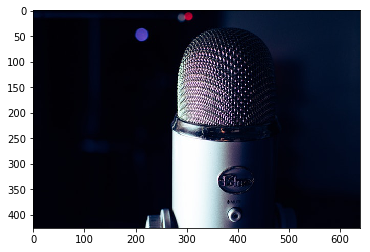

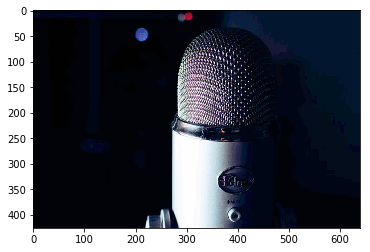

In [13]:
# Let's compress and uncompress some images.
print(len(images))
chosen_image_index = 2
show_image(images[chosen_image_index])
show_image(compressor.uncompress(compressor.compress(images[chosen_image_index])))

## Gaussian Mixture Models

The K-means algorithm is nice, but it's actually more limited compared to a better algorithm called the Gaussian Mixture Model.

**Exercise 10: Read section 9.2 (Mixtures of Gaussians) in [Pattern Recognition and Machine Learning](https://www.amazon.com/gp/product/0387310738/).**

http://www.cse.psu.edu/~rtc12/CSE586Spring2010/papers/prmlMixturesEM.pdf

**Exercise 11: Use a Gaussian Mixture Model instead of K-Means to compute the color palette in your code. Here is the scikit learn implementation of Gaussian Mixture Models:**

http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture